**Objetivos:**
Classificação binária - Brest Cancer (Cancer de mama)

* Maligno: O tumor é cancerígeno e pode se espalhar para outras partes do corpo.
* Benigno: O tumor não é cancerígeno e não se espalha.




Rede neural profunda (Deep Learning): Indicado quando temos bom processamento e alto volume de dados.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# biblioteca desenvolvida pelo Meta AI, muito utilizada para treinar e construir redes neurais profundas
import torch
torch.__version__

'2.4.1+cu121'

In [3]:
import torch.nn as nn

In [4]:
# São usados para definir a semente (seed) dos geradores de números aleatórios nas bibliotecas NumPy e PyTorch,
np.random.seed(123)
torch.manual_seed(123)
# Define a semente para os números aleatórios usados nas operações do PyTorch, como a inicialização de pesos de redes neurais e a aleatorização de dados durante o treinamento.

Teremos 2 arquivos, um de entradas de dados e um de saidas, iremos abaixo abrir esses arquivos:

In [5]:
features = pd.read_csv('entradas_breast.csv')

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0    radius_mean              569 non-null    float64
 1    texture_mean             569 non-null    float64
 2    perimeter_mean           569 non-null    float64
 3    area_mean                569 non-null    float64
 4    smoothness_mean          569 non-null    float64
 5    compactness_mean         569 non-null    float64
 6    concavity_mean           569 non-null    float64
 7   concave_points_mean       569 non-null    float64
 8    symmetry_mean            569 non-null    float64
 9    fractal_dimension_mean   569 non-null    float64
 10   radius_se                569 non-null    float64
 11   texture_se               569 non-null    float64
 12   perimeter_se             569 non-null    float64
 13   area_se                  569 non-null    float64
 14   smoothnes

In [7]:
previsoes = pd.read_csv('saidas_breast.csv')

In [8]:
previsoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       569 non-null    int64
dtypes: int64(1)
memory usage: 4.6 KB


Verificando balanceamento:

In [9]:
previsoes['0'].value_counts(normalize=True) * 100

,proportion
0,
1,62.741652
0,37.258348


Realizando divisão em treino e teste:

In [10]:
previsoes_train, previsoes_test, features_train, features_test = train_test_split(previsoes,
                                                                                  features,
                                                                                  test_size = 0.25)

In [11]:
previsoes_train.shape

(426, 1)

In [12]:
features_train.shape

(426, 30)

**Transformação dos dados para tensores:**

Como sabemos criamos nossos dados na estrutura de dataframes.

In [13]:
type(features_train)

pandas.core.frame.DataFrame

A transformação de dados para tensores é necessária quando se trabalha com PyTorch (ou outras bibliotecas de deep learning, como TensorFlow), porque os tensores são a estrutura de dados fundamental usada para representar e manipular números nesses frameworks.

Tensores são arrays multidimensionais que podem conter dados como números inteiros, números de ponto flutuante, entre outros.
Exemplos:

**Escalar:** Um número simples (0D tensor).

**Vetor:** Um array unidimensional (1D tensor).

**Matriz:** Um array bidimensional (2D tensor).

**Tensor:** Um array de mais dimensões (3D ou mais).

In [14]:
# começamos convertendendo em um array nosso df e em seguida criamos o tensor especificando que nossos dados devem ser do tipo float
features_train = torch.tensor(np.array(features_train), dtype=torch.float)

In [15]:
features_train

tensor([[1.1540e+01, 1.4440e+01, 7.4650e+01,  ..., 6.9180e-02, 2.3290e-01,
         8.1340e-02],
        [2.0310e+01, 2.7060e+01, 1.3290e+02,  ..., 1.6970e-01, 3.1510e-01,
         7.9990e-02],
        [1.1360e+01, 1.7570e+01, 7.2490e+01,  ..., 8.6980e-02, 2.9730e-01,
         7.7450e-02],
        ...,
        [1.2050e+01, 2.2720e+01, 7.8750e+01,  ..., 1.0920e-01, 2.1910e-01,
         9.3490e-02],
        [2.0440e+01, 2.1780e+01, 1.3380e+02,  ..., 1.7650e-01, 2.6090e-01,
         6.7350e-02],
        [1.1740e+01, 1.4690e+01, 7.6310e+01,  ..., 1.0560e-01, 2.6040e-01,
         9.8790e-02]])

In [16]:
previsoes_train = torch.tensor(np.array(previsoes_train), dtype=torch.float)

In [17]:
type(previsoes_train)

torch.Tensor

Criamos um objeto TensorDataset que é utilizado para armazenar os dados de entrada (features) e as respectivas saídas (previsões) como um único conjunto de dados.


Diferente dos outros métodos que trabalhamos com elas separadas:

In [18]:
dataset_treino = torch.utils.data.TensorDataset(features_train, previsoes_train)

In [19]:
train_loader = torch.utils.data.DataLoader(dataset_treino, batch_size=10, shuffle=True)
# batch_size=10:define quantas amostras serão carregadas em cada lote.

DataLoader é uma classe do PyTorch que permite carregar dados de forma eficiente em lotes (ou batches).
Ele fornece funcionalidades para iterar sobre o dataset, gerenciando o carregamento dos dados em memória de maneira otimizada, o que é especialmente útil para grandes conjuntos de dados.

**Batching e Embaralhamento:** A configuração do tamanho do lote e o embaralhamento ajudam a melhorar o desempenho do modelo durante o treinamento, evitando overfitting e melhorando a convergência.

**Criação do modelo:**

In [20]:
classificador = nn.Sequential(
    nn.Linear(in_features=30, out_features=16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

# Teremos 30 neuronios pois temos 30 features de entrada
# a primeira camada oculta com 16 neuronios
# segunda com 16
# terceira (saida) 1 neuronio

**nn.Sequential:** permite empilhar várias camadas de forma sequencial, onde a saída de uma camada se torna a entrada da próxima.

**nn.Linear(in_features=30, out_features=16):** Esta é a primeira camada da rede. É uma camada totalmente conectada (ou camada densa) que recebe 30 entradas (in_features=30) e produz 16 saídas (out_features=16).

**nn.ReLU():sta** é uma função de ativação chamada ReLU (Rectified Linear Unit). Ela aplica a função a cada elemento da saída da camada anterior, introduzindo não-linearidade ao modelo.

**nn.Linear(16, 16):** Esta é a segunda camada linear, que recebe 16 entradas (da camada anterior) e também produz 16 saídas.

**nn.Linear(16, 1):** Esta é a terceira camada linear, que reduz as 16 saídas para uma única saída.






In [21]:
classificador.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [22]:
criterion = nn.BCELoss()
# que é uma função de perda utilizada para problemas de classificação binária.
# A perda de entropia cruzada mede a diferença entre as distribuições de probabilidade previstas pelo modelo e as distribuições reais (ou verdadeiras) das classes.

In [23]:
optimizer = torch.optim.Adam(classificador.parameters(), lr=0.001, weight_decay=0.0001)
# O uso de Adam com uma taxa de aprendizado adequada e regularização ajuda a garantir que o modelo aprenda de forma eficiente, evitando problemas como o overfitting e promovendo uma convergência mais rápida e estável.

**Treinamento do modelo:**

Para fazer o treinamento não temos uma função da biblioteca então temos que fazer um for.

Loop de treinamento que se repete por 100 épocas.
O código treina um modelo de rede neural por 100 épocas, processando os dados em lotes, calculando a perda e atualizando os parâmetros do modelo em cada iteração.

Uma época é um ciclo completo através do conjunto de dados de treinamento. Isso significa que durante uma época, o modelo é alimentado com todos os dados de treinamento disponíveis uma vez, e cada amostra é usada para atualizar os parâmetros do modelo (pesos e biases).

**Durante cada época, os pesos do modelo são ajustados com base nas previsões feitas e na perda calculada. O objetivo é melhorar a precisão do modelo ao longo do tempo.**

In [24]:
for epoch in range(100):
  running_loss = 0.

  for data in train_loader:
    inputs, labels = data
    optimizer.zero_grad()

    outputs = classificador(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  print('Época %3d: perda %.5f' % (epoch+1, running_loss/len(train_loader)))

Época   1: perda 10.78336
Época   2: perda 2.84864
Época   3: perda 1.67480
Época   4: perda 1.11414
Época   5: perda 0.63996
Época   6: perda 0.63753
Época   7: perda 0.58066
Época   8: perda 0.55460
Época   9: perda 0.55617
Época  10: perda 0.53322
Época  11: perda 0.55797
Época  12: perda 0.53816
Época  13: perda 0.52938
Época  14: perda 0.33227
Época  15: perda 0.51360
Época  16: perda 0.35532
Época  17: perda 0.49602
Época  18: perda 0.33208
Época  19: perda 0.29349
Época  20: perda 0.25046
Época  21: perda 0.29527
Época  22: perda 0.49888
Época  23: perda 0.47241
Época  24: perda 0.45883
Época  25: perda 0.27544
Época  26: perda 0.23399
Época  27: perda 0.26373
Época  28: perda 0.24136
Época  29: perda 0.28275
Época  30: perda 0.22633
Época  31: perda 0.19294
Época  32: perda 0.22258
Época  33: perda 0.20290
Época  34: perda 0.20888
Época  35: perda 0.20335
Época  36: perda 0.20316
Época  37: perda 0.18855
Época  38: perda 0.22316
Época  39: perda 0.23315
Época  40: perda 0.19261

**Avaliação Modelo:**

In [25]:
classificador.eval()

Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [27]:
features_test = torch.tensor(np.array(features_test), dtype=torch.float)

Aqui nós realizamos as previsões para base de teste:

In [28]:
previsoes = classificador.forward(features_test)

In [29]:
previsoes

tensor([[9.9355e-01],
        [1.0000e+00],
        [3.6576e-01],
        [9.5613e-01],
        [1.7193e-04],
        [8.6620e-01],
        [9.5629e-01],
        [9.9984e-01],
        [6.8121e-01],
        [6.8945e-01],
        [9.4789e-01],
        [9.9813e-01],
        [8.9354e-01],
        [9.9553e-01],
        [9.9704e-01],
        [8.5391e-01],
        [9.9631e-01],
        [1.0000e+00],
        [3.8023e-01],
        [9.9742e-01],
        [8.3553e-10],
        [1.1818e-02],
        [4.8342e-01],
        [1.0000e+00],
        [9.1356e-01],
        [5.3865e-03],
        [8.6497e-01],
        [1.0000e+00],
        [2.4472e-04],
        [9.9782e-01],
        [5.5634e-01],
        [9.9999e-01],
        [8.9235e-01],
        [9.8796e-01],
        [4.3623e-01],
        [9.9818e-01],
        [6.4472e-01],
        [9.9853e-01],
        [9.9761e-01],
        [4.9669e-05],
        [7.6495e-03],
        [9.2132e-01],
        [1.3711e-07],
        [3.2506e-01],
        [8.6432e-05],
        [6

Quando o valor previsto tiver probabilidade > 0.5 então true!

In [30]:
previsoes = np.array(previsoes > 0.5)
previsoes

array([[ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [

In [33]:
taxa_acerto = accuracy_score(previsoes_test, previsoes)
taxa_acerto

0.8951048951048951

In [34]:
matriz = confusion_matrix(previsoes_test, previsoes)
matriz

array([[43, 11],
       [ 4, 85]])

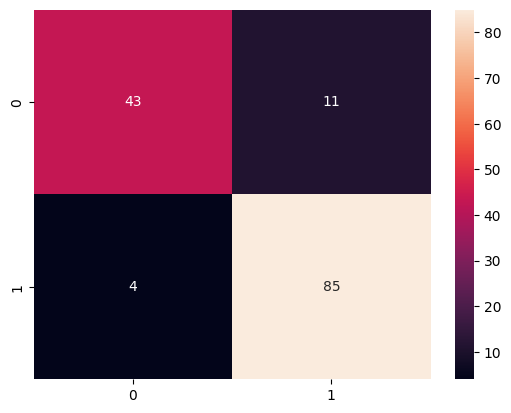

In [35]:
sns.heatmap(matriz, annot=True);